In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import random
import pandas as pd
import multiprocessing as mp
import numpy as np
import osmnx as ox
import json
import networkx as nx
import pickle
from data_utils import *
import matplotlib

from scipy.stats import pearsonr, gamma, kstest, ks_2samp, wilcoxon
from scipy.stats import ttest_rel, ttest_ind
from scipy.stats import friedmanchisquare
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import seaborn as sns
from acp import *

In [86]:
def len_if_group(all_it_path):
    all_it = pd.read_csv(all_it_path)

    it_if = all_it[all_it["type"] == "IF"]
    it_len = all_it[all_it["type"] == "LEN"]
    
    return it_if, it_len

def ks_2samp_test(group1, group2, alternative):
    KS, p_value = ks_2samp(group1, group2, alternative=alternative)
    print("KS statistics : ", KS)
    print("p-value : ", p_value)
    return KS, p_value

def test_students(group1, group2, alternative="two-sided"):
    """In order to compare the mean between the distribution of group 1 and group 2"""
    return ttest_rel(group1, group2, alternative=alternative)

def d_cohen(group1, group2):
    """In order to know if there is a size effect"""
    mean1 = np.mean(group1)
    mean2 = np.mean(group2)

    var1 = np.var(group1, ddof=1)
    var2 = np.var(group2, ddof=2)
    
    n1 = len(group1)
    n2 = len(group2)

    pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))

    return (mean1 - mean2) / pooled_std

def distance_cost(group1, group2):
    """Calculate the distance cost between itineraries"""
    d1 = np.array(group1["total_length"])
    d2 = np.array(group2["total_length"])

    percent_diff = ((d2-d1)/d1)*100

    return round(np.mean(percent_diff),2)

def select_most_frequent_index(frequency_data, quantile):
    limit_count = frequency_data["count"].quantile([quantile]).iloc[0]
    most_frequent = frequency_data[frequency_data["count"] >= limit_count]
    
    percent = (len(most_frequent)/len(frequency_data))*100
    
    print(f"percent most frequent :", percent)
    
    indexes_most_frequent = most_frequent.index.to_list()
    
    return indexes_most_frequent

def plot_data(data, name, max_y_value):
    # Calculate the common x-axis limits
    min_value = data.min()
    max_value = data.max()

    #Calculate the common y-axis limits
    min_y_value = 0
    max_y_value = max_y_value

    fig1 = plt.figure(figsize=(8, 6))
    plt.hist(data, bins=20, alpha=0.5, color="green")
    plt.xlabel(f"{name}")
    plt.ylabel("Frequency")
    plt.title(f"Histogram - {name}")
    plt.grid(True)
    plt.xlim(min_value, max_value)
    plt.ylim(min_y_value, max_y_value)

    mean = np.mean(data)
    var = np.var(data)
    std = np.std(data)
    quartiles = np.percentile(data, [25, 50, 75])
    sample_size = len(data)

    plt.axvline(mean, color='black', linestyle='dashed', linewidth=1)
    plt.axvline(quartiles[0], color='red', linestyle='dashed', linewidth=1)
    plt.axvline(quartiles[1], color='red', linestyle='solid', linewidth=1)
    plt.axvline(quartiles[2], color='red', linestyle='dashed', linewidth=1)

    plt.text(0.95, 0.95, f"Mean: {mean:.2f}\nVariance: {var:.2f}\nStd Deviation: {std:.2f}\n"
                         f"Q1: {quartiles[0]:.2f}\nQ2: {quartiles[1]:.2f}\nQ3: {quartiles[2]:.2f}\n"
                         f"Sample Size : {sample_size}",
             verticalalignment="top", horizontalalignment="right", transform=plt.gca().transAxes)

    plt.show()


def convert_score_on_ten(x, max):
    return (10/max)*x

def plot_distribution_by_category(dataframe, target_column, category_column, category_colors=None):
    """
    Plot the distribution of a target column colored by a category column.
    
    Parameters:
        dataframe (pd.DataFrame): The DataFrame containing the data.
        target_column (str): The column whose distribution will be plotted.
        category_column (str): The column used for coloring the distribution.
        category_colors (dict, optional): A dictionary specifying the colors for each category. 
                                          If not provided, default colors will be used.
    """
    if category_colors is None:
        category_colors = {}  # Default colors if not provided
        unique_categories = dataframe[category_column].unique()
        default_colors = plt.cm.tab10.colors
        for i, cat in enumerate(unique_categories):
            category_colors[cat] = default_colors[i % len(default_colors)]

    # Extract data for plotting
    data_to_plot = dataframe[[target_column, category_column]]

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot the histograms colored by category
    for cat, group in data_to_plot.groupby(category_column):
        ax1.hist(group[target_column], bins=10, alpha=0.6, color=category_colors[cat], label=cat)
        ax2.hist(group[target_column], bins=10, alpha=0.6, color=category_colors[cat], label=cat)

    # Calculate and display descriptive statistics
    descriptive_stats = dataframe.groupby(category_column)[target_column].describe()
    for cat in descriptive_stats.index:
        mean = descriptive_stats.loc[cat, 'mean']
        variance = descriptive_stats.loc[cat, 'std'] ** 2
        q25 = descriptive_stats.loc[cat, '25%']
        q50 = descriptive_stats.loc[cat, '50%']
        q75 = descriptive_stats.loc[cat, '75%']
        ax2.axvline(mean, color=category_colors[cat], linestyle='dashed', linewidth=1)
        ax2.axvline(q25, color=category_colors[cat], linestyle='dotted', linewidth=1)
        ax2.axvline(q50, color=category_colors[cat], linestyle='dotted', linewidth=1)
        ax2.axvline(q75, color=category_colors[cat], linestyle='dotted', linewidth=1)

    # Set plot properties
    ax1.set_xlabel(target_column)
    ax1.set_ylabel('Frequency')
    ax1.set_title(f'Distribution of {target_column} by {category_column}')
    ax1.legend()

    ax2.set_xlabel(target_column)
    ax2.set_title('Descriptive Statistics')
    ax2.grid(True)

    # Add a legend for descriptive statistics
    legend_elements = [plt.Line2D([0], [0], color=category_colors[cat], lw=1, label=cat) for cat in descriptive_stats.index]
    ax2.legend(handles=legend_elements, title=category_column)

    plt.tight_layout()
    plt.show()

    def sns_plot(data, variable):
        sns.set(rc={'axes.facecolor':'#f4f2f2', 'figure.facecolor':'#f4f2f2'})
        colour_palette = {"IF": "blue", "LEN": "red"}
        legend = {"IF": "Frais", "LEN": "Courts"}
        sns.displot(data, x=variable, kind="kde", hue="type", fill=True, legend=False, palette=colour_palette)

        plt.ylabel("Densité")
        plt.xlabel("")

        plt.legend(title="Types d'itinéraires", labels=legend.values())
        plt.show()

def sns_plot(data, variable):
    sns.set(rc={'axes.facecolor':'#f4f2f2', 'figure.facecolor':'#f4f2f2'})
    colour_palette = {"IF": "blue", "LEN": "red"}
    legend = {"IF": "Frais", "LEN": "Courts"}
    sns.displot(data, x=variable, kind="kde", hue="type", fill=True, legend=False, palette=colour_palette)

    plt.ylabel("Densité")
    plt.xlabel("")

    plt.legend(title="Types d'itinéraires", labels=legend.values())
    plt.show()

def basic_stats(data):
    return pd.DataFrame({
        "mean": np.mean(data),
        "var": np.var(data),
        "quantiles": np.quantile(data, q=[0.25,0.5,0.75])
    })

def basic_stats_key(key, column, hour=False, distinct_if_len=False):
    path = ""
    if(hour):
        path = f"./output_data/analyse/{key}/{hour}/mean_value_by_it{key}.csv"
    else:
        path = f"./output_data/analyse/{key}/mean_value_by_it{key}.csv"
    dataset = pd.read_csv(path)
    if(distinct_if_len):
        it_if = dataset[dataset["type"] == "IF"]
        it_len = dataset[dataset["type"] == "LEN"]

        return{
            "IF": basic_stats(it_if[column]),
            "LEN": basic_stats(it_len[column])
        }
    else:
        return(basic_stats(dataset[column]))
    
def basic_stats_temp_key(key, column, scaler, hour=False, distinct_if_len=False):
    path = ""
    if(hour):
        path = f"./output_data/analyse/{key}/{hour}/mean_value_by_it{key}.csv"
    else:
        path = f"./output_data/analyse/{key}/mean_value_by_it{key}.csv"
    dataset = pd.read_csv(path)

    dataset["real_temp"] = scaler.inverse_transform(dataset[[column]])

    # print(dataset["real_temp"])
    sns_plot(dataset, "real_temp")

    if(distinct_if_len):
        it_if = dataset[dataset["type"] == "IF"]
        it_len = dataset[dataset["type"] == "LEN"]

        return{
            "IF": basic_stats(it_if["real_temp"]),
            "LEN": basic_stats(it_len["real_temp"])
        }
    else:
        return(basic_stats(dataset[column]))

def compare_gain(it_if, it_len, printed=True, q=[0.25,0.5,0.75]):
    all_percent_diff = []
    for i, l in zip(it_if, it_len):
        percent = round(((i - l)/(l+0.000001))*100, 2)
        all_percent_diff.append(percent)
    
    if(printed):
        print("Gain quantiles : ", np.quantile(all_percent_diff, q=q))
        print("Gain mean : ", np.mean(all_percent_diff))
    return all_percent_diff

def print_quantiles_to_compare(key1, key2, column):
    dataset_1 = pd.read_csv(f"./output_data/analyse/{key1}/13h/mean_value_by_it{key1}.csv")
    if_it_1 = dataset_1[dataset_1["type"] == "IF"]

    dataset_2 = pd.read_csv(f"./output_data/analyse/{key2}/13h/mean_value_by_it{key2}.csv")
    if_it_2 = dataset_2[dataset_2["type"] == "IF"]

    print(f"{column}; {key1}", basic_stats(if_it_1[column]))
    print(f"{column}; {key2}", basic_stats(if_it_2[column]))

# def print_quantiles_to_compare_spec(key1, column):
#     dataset_1 = pd.read_csv(f"./output_data/analyse/{key1}/13h/mean_value_by_it{key1}.csv")
#     if_it_1 = dataset_1[dataset_1["type"] == "IF"]

#     print(f"{column}; {key1}", basic_stats(if_it_1[column]))
#     print(f"{column}; arbres : ", basic_stats(arbres_if))

def gain_compare_key(key, column, hour=False):
    path = ""
    if(hour):
        path = f"./output_data/analyse/{key}/{hour}/mean_value_by_it{key}.csv"
    else:
        path = f"./output_data/analyse/{key}/mean_value_by_it{key}.csv"
    dataset = pd.read_csv(path)
    # print(dataset.columns)
    if_it = dataset[dataset["type"] == "IF"]
    if_len = dataset[dataset["type"] == "LEN"]

    all_percent_diff = compare_gain(if_it[column], if_len[column])

    return all_percent_diff

## Prise en compte de la variable ombre

### Analyse des gains

Gain en ombre avec la pondération initiale en arbres

In [20]:
gain_ombres_ar10 = gain_compare_key("P0_01O0_01At0_01Ar10C0_01E0_01Ca0_01", "mean_ombres_13_prop", hour=False)

Gain quantiles :  [-33.33   0.     6.67]
Gain mean :  62580.23258895706


In [18]:
for w in range(9,0, -2):
    print("POID OMBRE : ", w)
    print("Arbres")
    gain__arbres = gain_compare_key(f"P0_01O{w}At0_01Ar10C0_01E0_01Ca0_01", "mean_arbres_prop")
    print("Ombres")
    gain__ombres = gain_compare_key(f"P0_01O{w}At0_01Ar10C0_01E0_01Ca0_01", "mean_ombres_13_prop")

POID OMBRE :  9
Arbres
Gain quantiles :  [ 0.   18.52 61.11]
Gain mean :  51.66840490797546
Ombres
Gain quantiles :  [ 0.   8.2 75. ]
Gain mean :  73681.39646625768
POID OMBRE :  7
Arbres
Gain quantiles :  [ 0.    23.26  74.455]
Gain mean :  59.9123190184049
Ombres
Gain quantiles :  [ 0.     0.    61.505]
Gain mean :  72445.8133006135
POID OMBRE :  5
Arbres
Gain quantiles :  [ 0.   31.25 91.67]
Gain mean :  67.01235582822086
Ombres
Gain quantiles :  [ 0.  0. 50.]
Gain mean :  69980.03887116564
POID OMBRE :  3
Arbres
Gain quantiles :  [  6.06   40.    107.845]
Gain mean :  81.19828220858896
Ombres
Gain quantiles :  [-10.725   0.     32.945]
Gain mean :  67513.94217177914
POID OMBRE :  1
Arbres
Gain quantiles :  [ 12.97  57.14 130.  ]
Gain mean :  98.74968098159508
Ombres
Gain quantiles :  [-25.     0.    14.29]
Gain mean :  73638.93857668713


In [31]:
basic_stats_key("P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01", "mean_ombres_13_prop", hour="13h", distinct_if_len=True)

{'IF':        mean       var  quantiles
 0  0.179975  0.034315       0.06
 1  0.179975  0.034315       0.12
 2  0.179975  0.034315       0.21,
 'LEN':        mean       var  quantiles
 0  0.086221  0.008556       0.03
 1  0.086221  0.008556       0.06
 2  0.086221  0.008556       0.11}

In [32]:
basic_stats_key("P0_01O5At0_01Ar10C0_01E0_01Ca0_01", "mean_ombres_13_prop", hour=False, distinct_if_len=True)

{'IF':        mean       var  quantiles
 0  0.102147  0.011456       0.03
 1  0.102147  0.011456       0.07
 2  0.102147  0.011456       0.12,
 'LEN':        mean       var  quantiles
 0  0.086221  0.008556       0.03
 1  0.086221  0.008556       0.06
 2  0.086221  0.008556       0.11}

In [33]:
basic_stats_key("P0_01O3At0_01Ar10C0_01E0_01Ca0_01", "mean_ombres_13_prop", hour=False, distinct_if_len=True)

{'IF':        mean       var  quantiles
 0  0.091546  0.009047       0.03
 1  0.091546  0.009047       0.06
 2  0.091546  0.009047       0.11,
 'LEN':        mean       var  quantiles
 0  0.086221  0.008556       0.03
 1  0.086221  0.008556       0.06
 2  0.086221  0.008556       0.11}

In [34]:
basic_stats_key("P0_01O5At0_01Ar10C0_01E0_01Ca0_01", "mean_arbres_prop", hour=False, distinct_if_len=True)

{'IF':       mean       var  quantiles
 0  0.32811  0.030696       0.20
 1  0.32811  0.030696       0.30
 2  0.32811  0.030696       0.44,
 'LEN':        mean       var  quantiles
 0  0.220245  0.014915       0.13
 1  0.220245  0.014915       0.20
 2  0.220245  0.014915       0.29}

In [35]:
basic_stats_key("P0_01O3At0_01Ar10C0_01E0_01Ca0_01", "mean_arbres_prop", hour=False, distinct_if_len=True)

{'IF':        mean       var  quantiles
 0  0.347939  0.033487       0.21
 1  0.347939  0.033487       0.32
 2  0.347939  0.033487       0.46,
 'LEN':        mean       var  quantiles
 0  0.220245  0.014915       0.13
 1  0.220245  0.014915       0.20
 2  0.220245  0.014915       0.29}

In [36]:
basic_stats_key("P0_01O0_01At0_01Ar10C0_01E0_01Ca0_01", "mean_arbres_prop", hour=False, distinct_if_len=True)

{'IF':        mean       var  quantiles
 0  0.398025  0.038378       0.25
 1  0.398025  0.038378       0.37
 2  0.398025  0.038378       0.54,
 'LEN':        mean       var  quantiles
 0  0.220245  0.014915       0.13
 1  0.220245  0.014915       0.20
 2  0.220245  0.014915       0.29}

## Prise en compte de la température

Pour la température, les données ont été normalisées et standardisées entre 0 et 1 afin que la pondération ait un sens, cependant, pour l'analyse, nous observons la vrai valeur de température afin de donner plus de sens.

In [62]:
from sklearn.preprocessing import MinMaxScaler

In [38]:
temp_edges_path = "./output_data/network/edges/edges_buffered_temp_wavg_bounding_no_na.gpkg"

In [44]:
def calculate_mean_prop(it, score_column):
    """Calculate the mean proportion of one column for a given itinerary"""
    # print(score_column)
    # print(it[score_column])
    return round(sum(it[score_column]*it["length"])/sum(it["length"]), 2)

def get_real_temperature(key, temp_edges_path, hour="13h"):
    """Get the real temperature for the edges of one dataset through all edges prop file"""
    # edges_it = gpd.read_file(f"./output_data/analyse/{key}/{hour}/dataset_{key}.gpkg")
    edges_it = gpd.read_file("./output_data/analyse/P0_01O0_01At0_01Ar0_01C10E0_01Ca0_01/13h/dataset_P0_01O0_01At0_01Ar0_01C10E0_01Ca0_01.gpkg")
    print("edges_it ok")
    all_edges_prop = gpd.read_file(temp_edges_path)
    print("temp edges ok")

    edges_it = edges_it.set_index(["uniqId"])
    all_edges_prop = all_edges_prop.set_index(["uniqId"])

    all_edges_prop_sample = all_edges_prop.loc[edges_it.index.to_list()]

    edges_it["C"] =  all_edges_prop_sample["C"]

    return edges_it


In [48]:
temp_edges = gpd.read_file("./output_data/network/edges/edges_buffered_temp_wavg_bounding_no_na.gpkg")

In [64]:
temp_scaler = MinMaxScaler(feature_range=(0, 1))
temp_scaler.fit(temp_edges[["C_wavg"]])


MinMaxScaler()

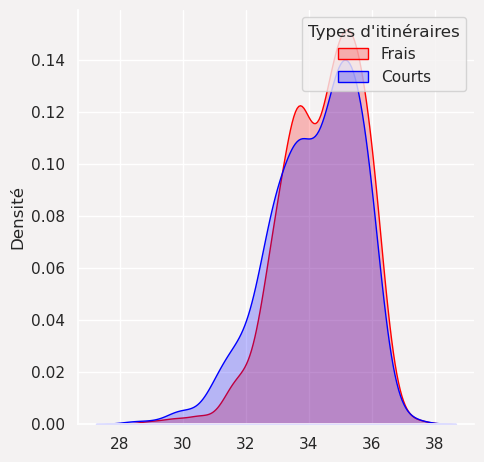

{'IF':         mean       var  quantiles
 0  34.175656  2.058617      33.30
 1  34.175656  2.058617      34.32
 2  34.175656  2.058617      35.34,
 'LEN':         mean       var  quantiles
 0  34.437018  1.619423      33.64
 1  34.437018  1.619423      34.66
 2  34.437018  1.619423      35.51}

In [87]:
basic_stats_temp_key("P0_01O0_01At0_01Ar0_01C10E0_01Ca0_01", "mean_C_wavg_scaled", temp_scaler, hour="13h", distinct_if_len=True)

In [47]:
basic_stats_key("P0_01O0_01At0_01Ar0_01C10E0_01Ca0_01", "mean_C_wavg_scaled", hour="13h", distinct_if_len=True)

{'IF':        mean       var  quantiles
 0  0.516209  0.005284      0.465
 1  0.516209  0.005284      0.520
 2  0.516209  0.005284      0.570,
 'LEN':        mean       var  quantiles
 0  0.496883  0.005604       0.45
 1  0.496883  0.005604       0.51
 2  0.496883  0.005604       0.56}

In [88]:
gain_temp_10 = gain_compare_key("P0_01O0_01At0_01Ar0_01C10E0_01Ca0_01", "mean_C_wavg_scaled", hour="13h")

Gain quantiles :  [-3.42  0.    0.  ]
Gain mean :  -3.2225398773006133
